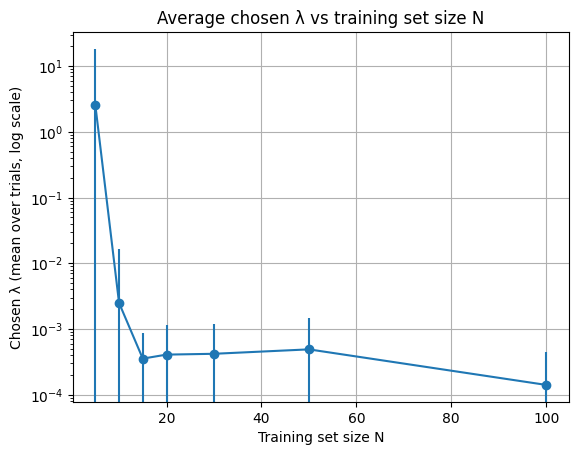

For N=10, optimal lambda (mean curve) is 3.71e-01


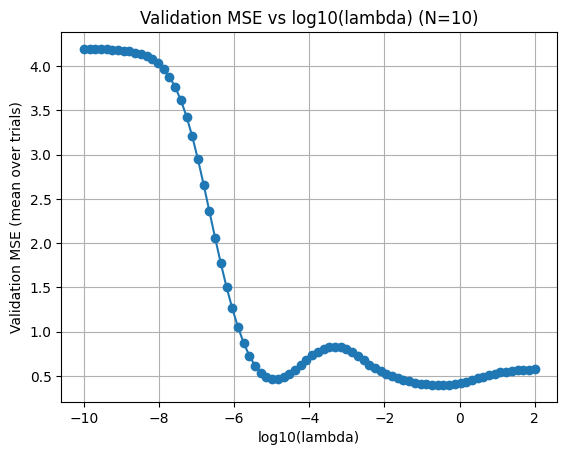

Summary table (shown above) gives mean, median, geometric mean, and std of chosen lambdas per N.
  N  mean_lambda  median_lambda  geom_mean_lambda  std_lambda  trials
  5     2.560699       0.000089      8.036432e-05   15.603570      40
 10     0.002497       0.000029      3.658400e-05    0.014277      40
 15     0.000355       0.000084      1.499510e-05    0.000528      40
 20     0.000409       0.000059      1.338389e-05    0.000724      40
 30     0.000421       0.000059      1.173871e-05    0.000755      40
 50     0.000491       0.000072      9.628182e-07    0.000960      40
100     0.000141       0.000072      3.615995e-07    0.000309      40
For N=100, optimal lambda (mean curve) is 1.19e-04


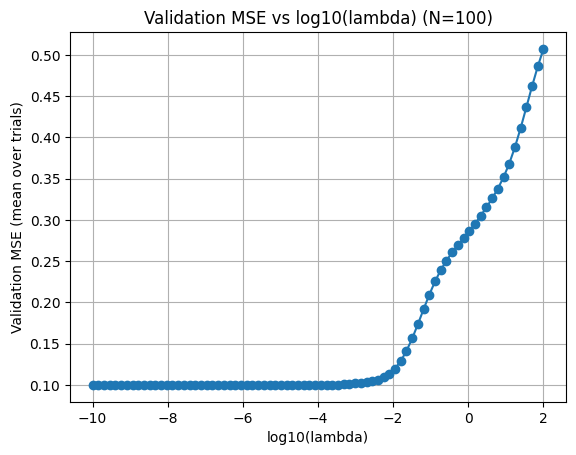

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import log10

np.random.seed(0)

def design_matrix(x, M):
    """Polynomial design matrix for inputs x (shape (N,)) and degree M.
       Returns (N, M+1) matrix with columns [1, x, x^2, ..., x^M]."""
    x = np.asarray(x)
    N = x.shape[0]
    X = np.vstack([x**i for i in range(M+1)]).T
    return X

def ridge_closed_form(X, y, lam):
    """Compute ridge regression solution w* = (X^T X + lam I)^{-1} X^T y"""
    # Use numpy.linalg.solve for numerical stability
    D = X.shape[1]
    A = X.T @ X + lam * np.eye(D)
    b = X.T @ y
    w = np.linalg.solve(A, b)
    return w

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# Experiment parameters
degree = 4          # polynomial degree M = 9 (Bishop example)
lam_grid = np.logspace(-10, 2, 80)  # grid of lambda values to search (very wide)
N_list = [5, 10, 15, 20, 30, 50, 100]  # different training set sizes to test
n_trials = 40      # independent trials per N
noise_std = 0.3

# Fixed validation set (large) and test set for stable selection
N_val = 100
x_val = np.random.rand(N_val)
y_val_clean = np.sin(2*np.pi*x_val)
y_val = y_val_clean + np.random.randn(N_val) * noise_std

results = []

# For storing per-N chosen lambdas
chosen_lambdas = {N: [] for N in N_list}

for N in N_list:
    for t in range(n_trials):
        x_train = np.random.rand(N)
        y_train = np.sin(2*np.pi*x_train) + np.random.randn(N) * noise_std

        X_train = design_matrix(x_train, degree)
        X_val = design_matrix(x_val, degree)

        val_mses = []
        for lam in lam_grid:
            w = ridge_closed_form(X_train, y_train, lam)
            y_val_pred = X_val @ w
            val_mses.append(mse(y_val, y_val_pred))
        val_mses = np.array(val_mses)
        best_idx = np.argmin(val_mses)
        best_lam = lam_grid[best_idx]
        chosen_lambdas[N].append(best_lam)
    # summarise
    arr = np.array(chosen_lambdas[N])
    results.append({
        "N": N,
        "mean_lambda": arr.mean(),
        "median_lambda": np.median(arr),
        "geom_mean_lambda": np.exp(np.mean(np.log(arr + 1e-30))),
        "std_lambda": arr.std(),
        "trials": len(arr)
    })

df = pd.DataFrame(results)


# Plot average optimal lambda vs N (log scale for lambda axis)
plt.figure()
means = df["mean_lambda"]
stds = df["std_lambda"]
Ns = df["N"]
plt.errorbar(Ns, means, yerr=stds, marker='o', linestyle='-')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel("Training set size N")
plt.ylabel("Chosen λ (mean over trials, log scale)")
plt.title("Average chosen λ vs training set size N")
plt.grid(True)
plt.show()

# For a representative N, plot validation MSE vs lambda (log lambda)
repN = 10
# compute mean validation curve across trials for repN
val_mses_all = []
for t in range(n_trials):
    x_train = np.random.rand(repN)
    y_train = np.sin(2*np.pi*x_train) + np.random.randn(repN) * noise_std
    X_train = design_matrix(x_train, degree)
    X_val = design_matrix(x_val, degree)
    val_mses = []
    for lam in lam_grid:
        w = ridge_closed_form(X_train, y_train, lam)
        y_val_pred = X_val @ w
        val_mses.append(mse(y_val, y_val_pred))
    val_mses_all.append(val_mses)
val_mses_mean = np.mean(val_mses_all, axis=0)

# print optimal lambda for repN
best_idx = np.argmin(val_mses_mean)
best_lambda = lam_grid[best_idx]
print(f"For N={repN}, optimal lambda (mean curve) is {best_lambda:.2e}")

plt.figure()
plt.plot(np.log10(lam_grid), val_mses_mean, marker='o', linestyle='-')
plt.xlabel("log10(lambda)")
plt.ylabel("Validation MSE (mean over trials)")
plt.title(f"Validation MSE vs log10(lambda) (N={repN})")
plt.grid(True)
plt.show()

# Also print a short summary
print("Summary table (shown above) gives mean, median, geometric mean, and std of chosen lambdas per N.")
print(df.to_string(index=False))

# For a representative N, plot validation MSE vs lambda (log lambda)
repN = 100
# compute mean validation curve across trials for repN
val_mses_all = []
for t in range(n_trials):
    x_train = np.random.rand(repN)
    y_train = np.sin(2*np.pi*x_train) + np.random.randn(repN) * noise_std
    X_train = design_matrix(x_train, degree)
    X_val = design_matrix(x_val, degree)
    val_mses = []
    for lam in lam_grid:
        w = ridge_closed_form(X_train, y_train, lam)
        y_val_pred = X_val @ w
        val_mses.append(mse(y_val, y_val_pred))
    val_mses_all.append(val_mses)
val_mses_mean = np.mean(val_mses_all, axis=0)

# print optimal lambda for repN
best_idx = np.argmin(val_mses_mean)
best_lambda = lam_grid[best_idx]
print(f"For N={repN}, optimal lambda (mean curve) is {best_lambda:.2e}")

plt.figure()
plt.plot(np.log10(lam_grid), val_mses_mean, marker='o', linestyle='-')
plt.xlabel("log10(lambda)")
plt.ylabel("Validation MSE (mean over trials)")
plt.title(f"Validation MSE vs log10(lambda) (N={repN})")
plt.grid(True)
plt.show()


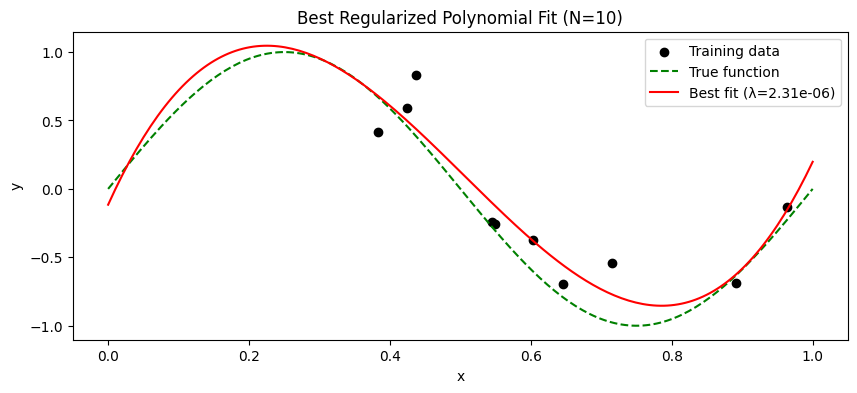

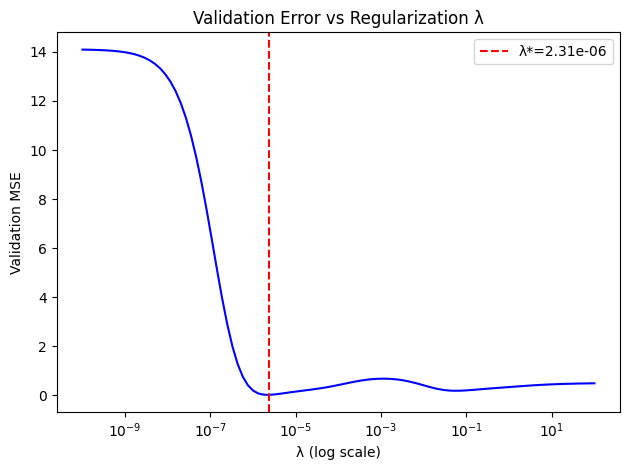

np.float64(2.310129700083158e-06)

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# === Settings ===
np.random.seed(0)
degree = 4
N = 10
noise_std = 0.3
lam_grid = np.logspace(-10, 2, 100)

# === Generate data ===
x_train = np.random.rand(N)
y_train = np.sin(2 * np.pi * x_train) + np.random.randn(N) * noise_std

x_val = np.linspace(0, 1, 200)
y_true = np.sin(2 * np.pi * x_val)

def design_matrix(x, M):
    return np.vstack([x**i for i in range(M + 1)]).T

def ridge_closed_form(X, y, lam):
    D = X.shape[1]
    A = X.T @ X + lam * np.eye(D)
    b = X.T @ y
    return np.linalg.solve(A, b)

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

X_train = design_matrix(x_train, degree)
X_val = design_matrix(x_val, degree)

# === Evaluate over λ ===
val_mses = []
models = []
for lam in lam_grid:
    w = ridge_closed_form(X_train, y_train, lam)
    y_val_pred = X_val @ w
    val_mses.append(mse(y_true, y_val_pred))
    models.append(w)

val_mses = np.array(val_mses)
best_idx = np.argmin(val_mses)
best_lambda = lam_grid[best_idx]
best_w = models[best_idx]

# === Plot results ===
plt.figure(figsize=(10, 4))

# (1) Fit curves
# plt.subplot(1, 2, 1)
plt.scatter(x_train, y_train, color="black", label="Training data")
plt.plot(x_val, y_true, "g--", label="True function")

y_pred_best = X_val @ best_w
plt.plot(x_val, y_pred_best, "r", label=f"Best fit (λ={best_lambda:.2e})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Best Regularized Polynomial Fit (N=10)")


plt.figure()


# (2) Validation error vs λ
# plt.subplot(1, 2, 2)
plt.semilogx(lam_grid, val_mses, "b-")
plt.axvline(best_lambda, color="r", linestyle="--", label=f"λ*={best_lambda:.2e}")
plt.xlabel("λ (log scale)")
plt.ylabel("Validation MSE")
plt.title("Validation Error vs Regularization λ")
plt.legend()

plt.tight_layout()
plt.show()

best_lambda
